Julia (like Python) strives for a lean standard library and leans on its rich ecosystem for extended capabilities such as ODE solving and plotting.
Beyond that, you'll probably notice that the syntax is very similar at this level; one big difference is that Python has zero-based indexing and Julia has one-based indexing!

Though for a script of this size, it doesn't make much of a difference, Julia offers some significant advantages for larger scale projects and in the integration of codes from different domains.

For instance, the late-compilation strategy of Julia means that there is no need to call into non-Julia libraries to squeeze out the last bit of performance from your code, and the execution of your code is relatively transparent.
The type system and multiple dispatch orientation Julia is built around allows you to, for instance, use a differential equation as a layer in your neural network code with a custom activation function, and the whole thing will work efficiently right out of the box.

Perhaps we'll have an opportunity to see some of how this help us later on when we leverage the [DifferentialEquations.jl](https://github.com/JuliaDiffEq/DifferentialEquations.jl) family of packages.

We'll use [Makie](https://github.com/JuliaPlots/Makie.jl) to create the plots in this example, but [PyPlot](https://github.com/JuliaPy/PyPlot.jl) would allow us to leverage `matplotlib` efficiently as well.

In [1]:
# This cell only needs to be run once per machine/Julia version:
using Pkg; Pkg.add("Makie"); Pkg.status()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Fetching: [========================================>]  100.0 %.0 %> ]  96.0 % Resolving package versions...
  Updating `~/.julia/environments/v0.7/Project.toml`
 [no changes]
  Updating `~/.julia/environments/v0.7/Manifest.toml`
 [no changes]
    Status `~/.julia/environments/v0.7/Project.toml`
  [12aac903] BinaryBuilder v0.0.4 #master (https://github.com/JuliaPackaging/BinaryBuilder.jl.git)
  [8f4d0f93] Conda v1.0.1
  [7073ff75] IJulia v1.11.1
  [ee78f7c6] Makie v0.9.0


In [1]:
a1 = 1
b1 = -1
a2 = 2
b2 = 1
function LotkaVolterra(t,y,dy)
    dy[1] = (a1 + b1*y[2])*y[1]
    dy[2] = (a2 + b2*y[1])*y[2]
    return dy
end

LotkaVolterra (generic function with 1 method)

This function can either be used to calculate `dy` in place:

In [2]:
y = zeros(2)
dy = ones(2)
LotkaVolterra(0, y, dy)
print(dy)

[0.0, 0.0]

It will also return the differential `dy` if you'd prefer to use it that way:

In [3]:
dy2 = LotkaVolterra(0, y, dy)
print(dy2)
@assert all(dy .== dy2) # Should be true.

[0.0, 0.0]

Euler's Method is nearly trivial to code up.
Note that I've swapped the meaning of the rows and columns compared to the Python implementation: in this formulation, the output `yOut` is a matrix with `nx0 = length(x0)` rows and `Nt` columns; each column is an output state.
Iterating over a matrix this way is more efficient in Julia.

In [4]:
function Euler(df, x0, t0, dt, Nt)
    nx0 = length(x0)
    yOut = zeros(nx0, Nt)
    tOut = zeros(Nt)
    yOut[:, 1] = copy(x0)
    df0 = zeros(nx0)
    tOut[1] = t0
    t = t0
    for i in 2:Nt
        t += dt
        df(t, x0, df0)
        x0 .+= dt * df0
        yOut[:, i] = copy(x0)
        tOut[i] = t
    end
    return tOut, yOut
end

x0 = [1.0, 1.0]
t0 = 0.0
dt = 1e-2
Nt = 100
ParamStr = string("a1=", a1, ", b1=", b1, ", a2=", a2, ", b1=", b1)
tOut, yOut = Euler(LotkaVolterra, x0, t0, dt, Nt)

([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  0.9, 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99], [1.0 1.0 … 0.0234126 0.0208974; 1.0 1.03 … 11.743 11.9806])

In [5]:
using Makie

You'll probably notice the _first_ time Makie is used to generate a plot, it'll take a while. There's [a solution](https://github.com/JuliaPlots/Makie.jl/) to this that's not too tricky to get working, if you care about such things.

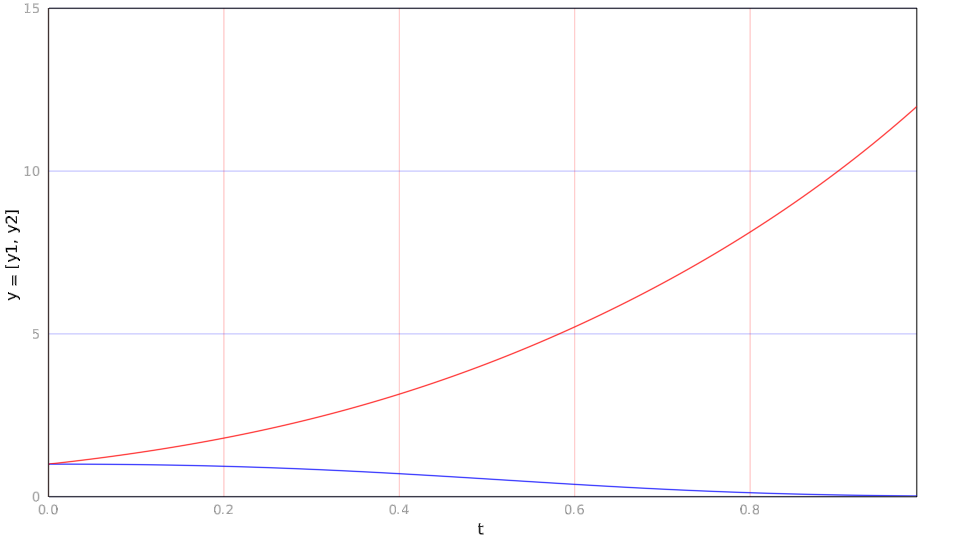

In [7]:
scene = Scene()
#= specify the scene limits, note that the arguments for FRect are
    x_min, y_min, x_dist, y_dist,
    therefore, the maximum x and y limits are then x_min + x_dist and y_min + y_dist
=#
limits = FRect(0, 0, maximum(tOut), 15)
lines!(scene, tOut, yOut[1, :], color = :blue, limits=limits)
lines!(scene, tOut, yOut[2, :], color = :red, limits=limits)
axis = scene[Axis] # get the axis object from the scene
axis[:grid][:linecolor] = ((:red, 0.5), (:blue, 0.5))
axis[:names][:axisnames] = ("t", "y = [y1, y2]")
scene

Makie is well-suited for interactive use because it is designed with performance in mind, but plots can be saved to a file for inclusion into e.g. a paper or presentation:

In [8]:
Makie.save("LotkaVolterraTimeEvolution.png", scene)

Though it can lead to inconsistent information if you're not careful, your plots look better if you use the built-in titling and labeling features that are native to Tikz/PGF and LaTeX rather than using Makie's functionality.

In [19]:
function samplePhasePortrait(f, y1v, y2v)
    dy1Vals = zeros(length(y1v), length(y2v))
    dy2Vals = copy(dy1Vals)
    dy = [0.0, 0.0]
    for (j, y2) in enumerate(y2v)
        for (i, y1) in enumerate(y1v)
            f(0, [y1, y2], dy)
            dy1Vals[i, j] = dy[1]
            dy2Vals[i, j] = dy[2]
        end
    end
    dy1Vals, dy2Vals
end
ny1 = 20
ny2 = 20
y1Vals = range(0,stop=10,length=ny1)
y2Vals = range(0,stop=10,length=ny2)
dy1Vals, dy2Vals = samplePhasePortrait(y1Vals, y2Vals)

([0.0 0.0 … -0.0 -0.0; 0.00263158 0.00124654 … -0.0222992 -0.0236842; … ; 0.0473684 0.0224377 … -0.401385 -0.426316; 0.05 0.0236842 … -0.423684 -0.45], [0.0 0.00526316 … 0.0947368 0.1; 0.0 0.0066482 … 0.119668 0.126316; … ; 0.0 0.0301939 … 0.54349 0.573684; 0.0 0.0315789 … 0.568421 0.6])

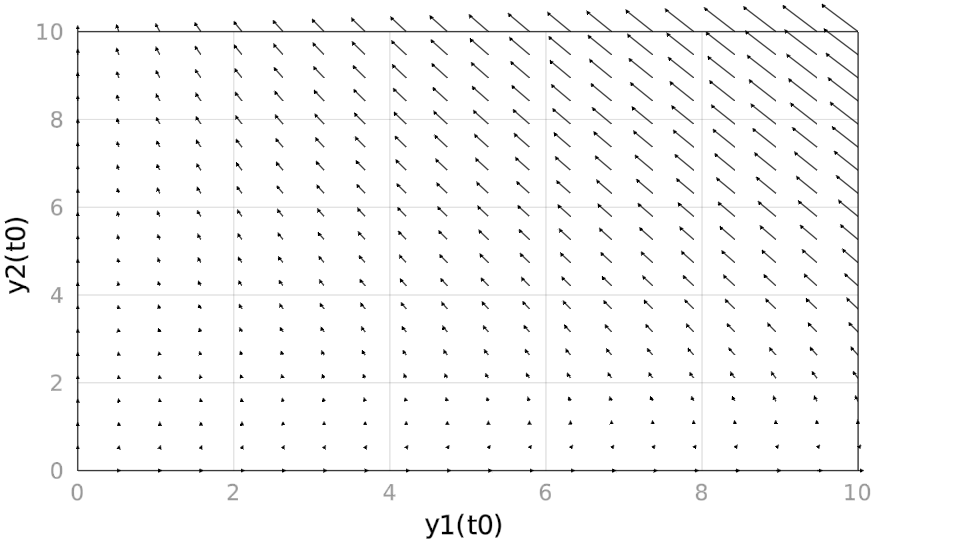

In [20]:
quiverScene = Scene()
limits = FRect(0, 0, 10, 10)
arrows!(y1Vals, y2Vals, dy1Vals, dy2Vals, arrowsize = 0.1, limits=limits, scale=1e-2*ones(3))
axis = quiverScene[Axis] # get the axis object from the scene
axis[:names][:axisnames] = ("y1(t0)", "y2(t0)")
quiverScene

Just to show off the interactivity that Makie provides, as well as the flexibility offered by Julia's compact syntax, we're going to give a quick example (WIP)

Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:α=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64}("ob_152", 0, Any[SyncCallback(Scope("knockout-component-a9d863f5-1425-4238-97f3-36706acfddf5", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["α"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>10,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any}("ob_150", ["-1.0", "-0.777778", "-0.555556", "-0.333333", "-0.111111", "0.111111", "0.333333", "0.555556", "0.777778", "1.0"], Any[SyncCallback(Scope(#= circular reference @-6 =#), SyncCallback(Scope(#= circular reference @-7 =#), ##39#41{Scope,String}(Scope(#= circular reference @-8 =#), "formatted_vals")))]), nothing),"changes"=>(Observable{Int64}(#= circular reference @-6 =#), nothing),"formatted_value"=>(Observable{String}("ob_151", "-0.111111", Any[SyncCallback(Scope(#= circular reference @-6 =#), SyncCallback(Scope(#= circular reference @-7 =#), ##39#41{Scope,String}(Scope(#= circular reference @-8 =#), "formatted_value")))]), nothing),"index"=>(Observable{Any}("ob_149", 5, Any[##25#28{##70#73,Observable{Float64},Array{Function,1}}(##70#73(Box(-1.0:0.2222222222222222:1.0)), Observable{Float64}("ob_148", -0.111111, Any[##24#27{##68#71,Observable{Any},Array{Function,1}}(##68#71(Box(-1.0:0.2222222222222222:1.0)), Observable{Any}(#= circular reference @-6 =#), Function[##24#27{##68#71,Observable{Any},Array{Function,1}}(#= circular reference @-2 =#), ##25#28{##70#73,Observable{Float64},Array{Function,1}}(#= circular reference @-5 =#)]), #g#15{##16#17{##45#48,Observable{Any}},NTuple{4,Observable{Float64}}}(##16#17{##45#48,Observable{Any}}(##45#48(), Observable{Any}("ob_168", Scene(Events(6141: "window_area" = GeometryTypes.HyperRectangle{2,Int64}([0, 0], [1, 1]) GeometryTypes.HyperRectangle{2,Int64} , 6142: "window_dpi" = 100.0 Float64 , 6143: "window_open" = false Bool , 6144: "mousebuttons" = Set(AbstractPlotting.Mouse.Button[]) Set{AbstractPlotting.Mouse.Button} , 6145: "mouseposition" = (0.0, 0.0) Tuple{Float64,Float64} , 6146: "mousedrag" = notpressed AbstractPlotting.Mouse.DragEnum , 6147: "scroll" = (0.0, 0.0) Tuple{Float64,Float64} , 6148: "keyboardbuttons" = Set(AbstractPlotting.Keyboard.Button[]) Set{AbstractPlotting.Keyboard.Button} , 6149: "unicode_input" = Char[] Array{Char,1} , 6150: "dropped_files" = String[] Array{String,1} , 6151: "hasfocus" = false Bool , 6152: "entered_window" = false Bool ), 6153: "foldp(window_area)-14" = GeometryTypes.HyperRectangle{2,Int64}([0, 0], [960, 540]) GeometryTypes.HyperRectangle{2,Int64} , Camera(6154: "input-1720" = Float32[1.0 0.0 0.0 0.0; 0.0 1.0 0.0 -182.696; 0.0 0.0 1.0 0.0; 0.0 0.0 0.0 1.0] StaticArrays.SArray{Tuple{4,4},Float32,2,16} , 6155: "input-1721" = Float32[0.00297673 0.0 0.0 -0.0; 0.0 0.00529196 0.0 -0.0; 0.0 0.0 -0.0001 -0.0; 0.0 0.0 0.0 1.0] StaticArrays.SArray{Tuple{4,4},Float32,2,16} , 6156: "input-1722" = Float32[0.00297673 0.0 0.0 0.0; 0.0 0.00529196 0.0 -0.966822; 0.0 0.0 -0.0001 0.0; 0.0 0
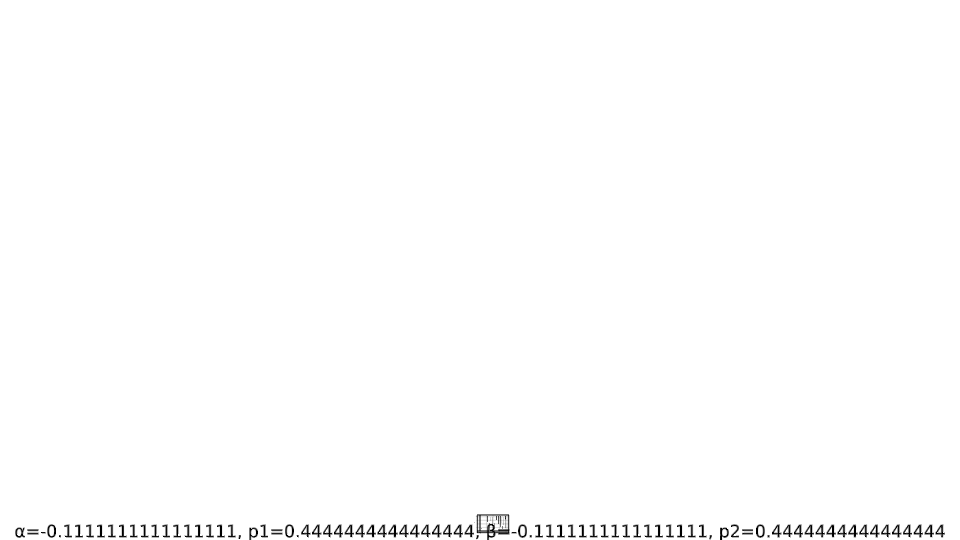
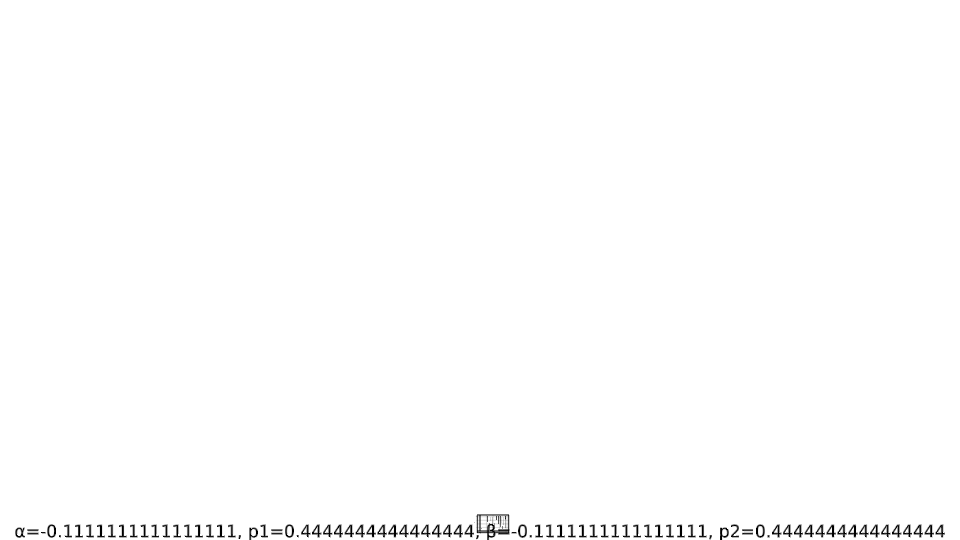

In [28]:
ny1 = 15
ny2 = 15
y1Vals = range(0,stop=10,length=ny1)
y2Vals = range(0,stop=10,length=ny2)
function doQuiver(scene, dy1, dy2, title)
    limits = FRect(0, 0, 10, 10)
    arrows!(scene, y1Vals, y2Vals, dy1, dy2, arrowsize = 0.1, limits=limits)
    axis = scene[Axis] # get the axis object from the scene
    axis[:names][:axisnames] = ("y1(t0)", "y2(t0)") 
    text!(scene, title, position=(0, 0), textsize = 12, align = (:center, :center))
    scene
end

scene = Scene()
ui = @manipulate for α in range(-1,stop=1,length=10), β in range(-1,stop=1,length=10), p1 in range(0,stop=1,length=10), p2 in range(0,stop=1,length=10)
    dy1Vals, dy2Vals = samplePhasePortrait(
        (t, y, dy) -> (dy[1]=(α - p1*y[2])*y[1]/200; dy[2]=(-β + p2*y[1])*y[2]/200),
        y1Vals, y2Vals
    )
    ParamStr = string("α=", α, ", p1=", p1, ", β=", β, ", p2=", p2)
    doQuiver(scene, dy1Vals, dy2Vals, ParamStr)
    scene
end